In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import dask.bag as db
from dask.distributed import Client
client = Client()
# check status at: http://localhost:8787/status

In [2]:
base_fn = "smlouvy"
# base_fn = "smlouvy-2018-01-26"

data_base_fn = f"data/hlidac/{base_fn}_lines_*.txt.gz"

In [3]:
lines = db.read_text(data_base_fn)
lines.map(json.loads).take(1)[0].keys()

dict_keys(['identifikator', 'schvalil', 'hodnotaBezDph', 'hodnotaVcetneDph', 'ciziMena', 'platnyZaznam', 'PravniRamec', 'Prilohy', 'LastUpdate', 'CalculatedPriceWithVATinCZK', 'CalcutatedPriceQuality', 'Issues', 'Enhancements', 'ConfidenceValue', 'Id', 'odkaz', 'casZverejneni', 'VkladatelDoRejstriku', 'Platce', 'Prijemce', 'predmet', 'datumUzavreni', 'cisloSmlouvy', 'navazanyZaznam', 'souvisejiciSmlouvy'])

In [4]:
a = lines.map(json.loads).take(1)[0]

In [5]:
a

{'CalculatedPriceWithVATinCZK': 59146,
 'CalcutatedPriceQuality': 1,
 'ConfidenceValue': 0,
 'Enhancements': [{'Changed': {'NewValue': '',
    'ParameterName': 'item.Prilohy[0].PlainTextContent',
    'PreviousValue': ''},
   'Created': '2016-11-05T21:51:50.3052753+01:00',
   'Description': '',
   'EnhancerType': 'HlidacSmluv.Plugin.Enhancers.TextMiner',
   'Public': True,
   'Title': 'Text přílohy extrahován přímé z dokumentu'}],
 'Id': '112125',
 'Issues': [],
 'LastUpdate': '2017-07-05T08:44:03.0477241+02:00',
 'Platce': {'adresa': 'Těšínská 1349/296 71600 Ostrava-Radvanice',
  'datovaSchranka': 'mfecgmh',
  'ico': '19010290',
  'nazev': 'Pharmos,a.s.Ostrava',
  'utvar': 'Obchodní oddělení'},
 'PravniRamec': 1,
 'Prijemce': [{'adresa': 'Šrobárova 1150/50, 10034 Praha 10, CZ',
   'datovaSchranka': 'zizdbpb',
   'ico': '00064173',
   'nazev': 'Fakultní nemocnice Královské Vinohrady',
   'utvar': None}],
 'Prilohy': [{'ContentType': 'text/plain; charset=windows-1252',
   'DatlClassifica

In [6]:
# Enhancements, ConfidenceValue, Issues, Platce, Prijemce, PravniRamec, Prilohy, VkladatelDoRejstriku, ciziMena, platnyZaznam, navazanyZaznam, schvalil, souvisejiciSmlouvy
def extract_fields(contract):
    return (contract['Id'], contract['CalculatedPriceWithVATinCZK'], contract['CalcutatedPriceQuality'], 
            contract['hodnotaBezDph'], contract['hodnotaVcetneDph'], 
            contract['casZverejneni'], contract['datumUzavreni'],
            contract['platnyZaznam'], contract['navazanyZaznam'])
columns = [('Id', np.object), 
           ('CalculatedPriceWithVATinCZK', np.float64),
           ('CalcutatedPriceQuality', np.float64),
           ('hodnotaBezDph', np.float64),
           ('hodnotaVcetneDph', np.float64),
           ('casZverejneni', np.object),
           ('datumUzavreni', np.object),
           ('platnyZaznam', np.bool),
           ('navazanyZaznam', np.object)]

In [7]:
data = lines.map(json.loads).map(extract_fields)
df_ = data.to_dataframe(columns)
df_

,Id,CalculatedPriceWithVATinCZK,CalcutatedPriceQuality,hodnotaBezDph,hodnotaVcetneDph,casZverejneni,datumUzavreni,platnyZaznam,navazanyZaznam
npartitions=105,,,,,,,,,
,object,float64,float64,float64,float64,object,object,bool,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [8]:
df = df_.compute()
df.head()

,Id,CalculatedPriceWithVATinCZK,CalcutatedPriceQuality,hodnotaBezDph,hodnotaVcetneDph,casZverejneni,datumUzavreni,platnyZaznam,navazanyZaznam
0,112125,59146.0,1.0,53769.25,59146.0,2016-08-18T11:48:56+02:00,2016-07-12T00:00:00,True,None
1,408857,536042.1,2.0,443010.00,NaN,2016-10-17T16:36:59+02:00,2016-10-17T00:00:00,True,None
2,1304117,26000.0,1.0,26000.00,26000.0,2017-02-22T09:38:37+01:00,2017-02-15T00:00:00,True,None
3,3107846,152738.3,2.0,126230.00,NaN,2017-09-11T09:53:50+02:00,2011-01-10T00:00:00,True,None
4,287073,363000.0,2.0,300000.00,NaN,2016-09-23T12:42:36+02:00,2016-09-20T00:00:00,True,None


In [9]:
df = df.set_index('Id')

In [11]:
len(df)

1049566

In [10]:
df.isnull().sum()

CalculatedPriceWithVATinCZK         0
CalcutatedPriceQuality              0
hodnotaBezDph                  372132
hodnotaVcetneDph               530585
casZverejneni                       0
datumUzavreni                       0
platnyZaznam                        0
navazanyZaznam                 966514
dtype: int64

In [72]:
df['platnyZaznam'].value_counts()

True     1049522
False         44
Name: platnyZaznam, dtype: int64

### Prices

In [12]:
df['CalcutatedPriceQuality'].value_counts()

1.0    514714
2.0    315381
0.0    219471
Name: CalcutatedPriceQuality, dtype: int64

In [29]:
print('original price not null')
(df['hodnotaBezDph'].notnull() | df['hodnotaVcetneDph'].notnull()).sum()

original price not null


831300

In [31]:
print('price with and without VAT known')
both_known = df[df['hodnotaBezDph'].notnull() & df['hodnotaVcetneDph'].notnull() & (df['hodnotaVcetneDph'] > 0)]
len(both_known)

price with and without VAT known


360985

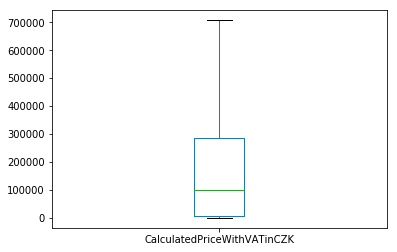

In [39]:
df['CalculatedPriceWithVATinCZK'].plot.box(showfliers=False)

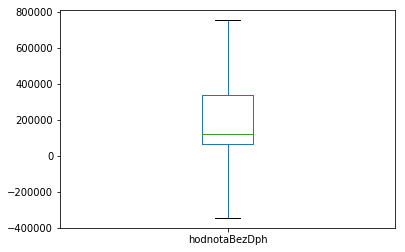

In [42]:
df['hodnotaBezDph'].plot.box(showfliers=False)

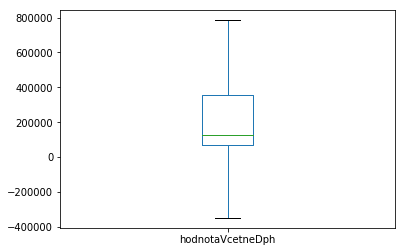

In [43]:
df['hodnotaVcetneDph'].plot.box(showfliers=False)

VAT percentage


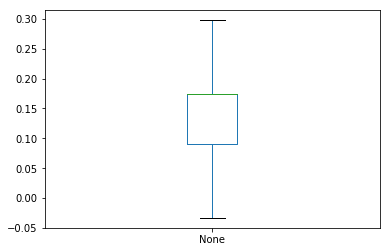

In [45]:
print('VAT percentage')
((both_known['hodnotaVcetneDph'] - both_known['hodnotaBezDph']) / both_known['hodnotaVcetneDph']).plot.box(showfliers=False)

### Dates

In [52]:
df['casZverejneni'] = pd.to_datetime(df['casZverejneni'])
# df['datumUzavreni'] = pd.to_datetime(df['datumUzavreni'])

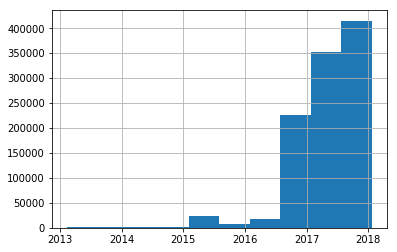

In [53]:
df['casZverejneni'].hist()

## Next batch

In [84]:
lines.map(json.loads).take(10)[2]['schvalil']

'Eva Měřínská'

In [86]:
# PravniRamec, VkladatelDoRejstriku, schvalil, souvisejiciSmlouvy
def extract_fields2(contract):
    platce = contract['Platce']
    n_enh = len(contract['Enhancements'])
    n_iss = len(contract['Issues'])
    n_prij = len(contract['Prijemce'])
    n_pril = len(contract['Prilohy'])
    return (platce['adresa'], platce['datovaSchranka'], platce['ico'], 
            platce['nazev'], contract['ConfidenceValue'], 
            n_enh, n_iss, n_prij, n_pril,
            contract['ciziMena'], contract['schvalil'])
columns2 = [('adresa', np.object), 
           ('datovaSchranka', np.object),
           ('ico', np.object),
           ('nazev', np.object),
           ('ConfidenceValue', np.object),
           ('n_enhancements', np.int),
           ('n_issues', np.int),
           ('n_prijemce', np.int),
           ('n_priloha', np.int),
           ('ciziMena', np.object),
           ('schvalil', np.object)]

In [87]:
data2 = lines.map(json.loads).map(extract_fields2)
df2_ = data2.to_dataframe(columns2)
df2_

,adresa,datovaSchranka,ico,nazev,ConfidenceValue,n_enhancements,n_issues,n_prijemce,n_priloha,ciziMena,schvalil
npartitions=105,,,,,,,,,,,
,object,object,object,object,object,int32,int32,int32,int32,object,object
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [88]:
df2 = df2_.compute()
df2.head()

,adresa,datovaSchranka,ico,nazev,ConfidenceValue,n_enhancements,n_issues,n_prijemce,n_priloha,ciziMena,schvalil
0,Těšínská 1349/296 71600 Ostrava-Radvanice,mfecgmh,19010290,"Pharmos,a.s.Ostrava",0,1,0,1,1,None,None
1,"Husinecká 1024/11a, 13000 Praha 3, CZ",z49per3,01312774,Státní pozemkový úřad,0,1,1,1,1,None,None
2,"Jiráskova 1775,39001 Tábor",g9bk5h7,70886334,Městská knihovna Tábor,-1,4,1,1,2,None,Eva Měřínská
3,"Naskové 996/14, Košíře, 15000, Praha 5",gqn7zmk,27913830,GELAI Company s.r.o.,20,2,1,1,2,None,None
4,"U Jezu 642/2a, 46001 Liberec, CZ",c5kbvkw,70891508,Liberecký kraj,0,0,0,1,1,None,None


In [90]:
len(df2)

1049566

In [92]:
df2.isnull().sum()

adresa               54646
datovaSchranka       19295
ico                  10022
nazev                    0
ConfidenceValue          0
n_enhancements           0
n_issues                 0
n_prijemce               0
n_priloha                0
ciziMena           1027512
schvalil            688426
dtype: int64

In [94]:
df2.ConfidenceValue.value_counts().head(10)

 0     657125
 5     135547
-1      86905
 10     62283
 20     60261
 25     21639
 19      9661
 30      3615
 40      2842
 4       2129
Name: ConfidenceValue, dtype: int64

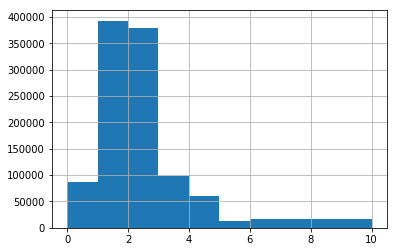

In [105]:
df2.n_enhancements.hist(bins=[0, 1, 2, 3, 4, 5, 6, 10])

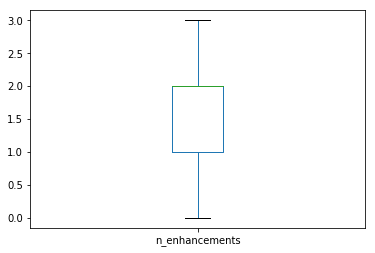

In [107]:
df2.n_enhancements.plot.box(showfliers=False)

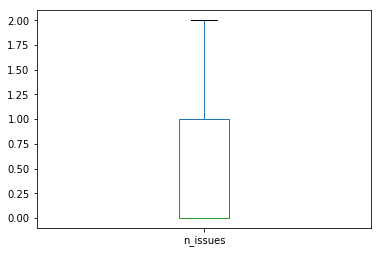

In [108]:
df2.n_issues.plot.box(showfliers=False)

In [111]:
df2.n_prijemce.describe()

count    1.049566e+06
mean     1.024083e+00
std      5.179437e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.410000e+02
Name: n_prijemce, dtype: float64

In [112]:
df2.n_priloha.describe()

count    1.049566e+06
mean     1.487562e+00
std      2.675533e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.644000e+03
Name: n_priloha, dtype: float64